In [11]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import warnings

from tqdm.notebook import tqdm
warnings.filterwarnings("ignore")

In [12]:
def identify_pinbar(df, body_threshold=0.2, wick_threshold=3):
    # Вычисляем длины тела и теней
    df['body'] = abs(df['close'] - df['open'])
    df['upper_wick'] = df['high'] - df[['open', 'close']].max(axis=1)
    df['lower_wick'] = df[['open', 'close']].min(axis=1) - df['low']
    df['candle_length'] = df['high'] - df['low']
    
    # Определяем бычий и медвежий pinbar
    df['bullish_pinbar'] = (
        (df['body'] <= df['candle_length'] * body_threshold) &  # Маленькое тело
        (df['lower_wick'] >= df['body'] * wick_threshold) &      # Длинная нижняя тень
        (df['upper_wick'] <= df['body'])                         # Короткая верхняя тень
    )

    df['bearish_pinbar'] = (
        (df['body'] <= df['candle_length'] * body_threshold) &  # Маленькое тело
        (df['upper_wick'] >= df['body'] * wick_threshold) &     # Длинная верхняя тень
        (df['lower_wick'] <= df['body'])                        # Короткая нижняя тень
    )

    return df

def backtest_pinbar_strategy(df, stop_loss_factor=1.02, take_profit_factor=2):
    # Сохраняем результаты торговли
    results = {
        'date': [],
        'signal': [],
        'entry_price': [],
        'stop_loss': [],
        'take_profit': [],
        'exit_price': [],
        'exit_reason': []
    }

    for index, row in df.iterrows():
        # Определяем числовой индекс для текущей строки
        current_idx = df.index.get_loc(index)

        # Определяем сигнал на покупку (бычий pinbar)
        if row['bullish_pinbar']:
            entry_price = row['close']
            stop_loss = row['low'] * (1 - 0.01)  # stop-loss немного ниже нижнего фитиля
            take_profit = entry_price + (entry_price - stop_loss) * take_profit_factor  # take-profit в несколько раз выше риска
            
            # Эмуляция бэктеста (ищем выход по stop-loss или take-profit в следующих свечах)
            for i in range(current_idx + 1, len(df)):
                high, low = df.iloc[i]['high'], df.iloc[i]['low']
                if low <= stop_loss:
                    results['date'].append(df.index[i])
                    results['signal'].append('Buy')
                    results['entry_price'].append(entry_price)
                    results['stop_loss'].append(stop_loss)
                    results['take_profit'].append(take_profit)
                    results['exit_price'].append(stop_loss)
                    results['exit_reason'].append('Stop Loss')
                    break
                elif high >= take_profit:
                    results['date'].append(df.index[i])
                    results['signal'].append('Buy')
                    results['entry_price'].append(entry_price)
                    results['stop_loss'].append(stop_loss)
                    results['take_profit'].append(take_profit)
                    results['exit_price'].append(take_profit)
                    results['exit_reason'].append('Take Profit')
                    break

        # Определяем сигнал на продажу (медвежий pinbar)
        elif row['bearish_pinbar']:
            entry_price = row['close']
            stop_loss = row['high'] * (1 + 0.01)  # stop-loss немного выше верхнего фитиля
            take_profit = entry_price - (stop_loss - entry_price) * take_profit_factor  # take-profit в несколько раз дальше риска
            
            # Эмуляция бэктеста
            for i in range(current_idx + 1, len(df)):
                high, low = df.iloc[i]['high'], df.iloc[i]['low']
                if high >= stop_loss:
                    results['date'].append(df.index[i])
                    results['signal'].append('Sell')
                    results['entry_price'].append(entry_price)
                    results['stop_loss'].append(stop_loss)
                    results['take_profit'].append(take_profit)
                    results['exit_price'].append(stop_loss)
                    results['exit_reason'].append('Stop Loss')
                    break
                elif low <= take_profit:
                    results['date'].append(df.index[i])
                    results['signal'].append('Sell')
                    results['entry_price'].append(entry_price)
                    results['stop_loss'].append(stop_loss)
                    results['take_profit'].append(take_profit)
                    results['exit_price'].append(take_profit)
                    results['exit_reason'].append('Take Profit')
                    break

    # Формируем DataFrame с результатами
    results_df = pd.DataFrame(results).sort_index()
    return results_df

def backtest_pinbar_with_filters(df, ema_period=50, atr_period=14, atr_multiplier=1.5):
    # Добавляем EMA и ATR в DataFrame
    df['EMA'] = df['close'].ewm(span=ema_period, adjust=False).mean()
    df['ATR'] = df['high'].rolling(window=atr_period).max() - df['low'].rolling(window=atr_period).min()

    # Сохраняем результаты торговли
    results = {
        'date': [],
        'signal': [],
        'entry_price': [],
        'stop_loss': [],
        'take_profit': [],
        'exit_price': [],
        'exit_reason': []
    }

    for index, row in df.iterrows():
        current_idx = df.index.get_loc(index)

        # Условие на покупку: бычий pinbar и цена выше EMA
        if row['bullish_pinbar'] and row['close'] > row['EMA']:
            entry_price = row['close']
            stop_loss = row['low'] - row['ATR'] * atr_multiplier  # Stop-loss на уровне ATR ниже
            take_profit = entry_price + (entry_price - stop_loss) * 2  # Take-profit в 2 раза дальше риска
            
            for i in range(current_idx + 1, len(df)):
                high, low = df.iloc[i]['high'], df.iloc[i]['low']
                if low <= stop_loss:
                    results['date'].append(df.index[i])
                    results['signal'].append('Buy')
                    results['entry_price'].append(entry_price)
                    results['stop_loss'].append(stop_loss)
                    results['take_profit'].append(take_profit)
                    results['exit_price'].append(stop_loss)
                    results['exit_reason'].append('Stop Loss')
                    break
                elif high >= take_profit:
                    results['date'].append(df.index[i])
                    results['signal'].append('Buy')
                    results['entry_price'].append(entry_price)
                    results['stop_loss'].append(stop_loss)
                    results['take_profit'].append(take_profit)
                    results['exit_price'].append(take_profit)
                    results['exit_reason'].append('Take Profit')
                    break

        # Условие на продажу: медвежий pinbar и цена ниже EMA
        elif row['bearish_pinbar'] and row['close'] < row['EMA']:
            entry_price = row['close']
            stop_loss = row['high'] + row['ATR'] * atr_multiplier  # Stop-loss на уровне ATR выше
            take_profit = entry_price - (stop_loss - entry_price) * 2  # Take-profit в 2 раза дальше риска
            
            for i in range(current_idx + 1, len(df)):
                high, low = df.iloc[i]['high'], df.iloc[i]['low']
                if high >= stop_loss:
                    results['date'].append(df.index[i])
                    results['signal'].append('Sell')
                    results['entry_price'].append(entry_price)
                    results['stop_loss'].append(stop_loss)
                    results['take_profit'].append(take_profit)
                    results['exit_price'].append(stop_loss)
                    results['exit_reason'].append('Stop Loss')
                    break
                elif low <= take_profit:
                    results['date'].append(df.index[i])
                    results['signal'].append('Sell')
                    results['entry_price'].append(entry_price)
                    results['stop_loss'].append(stop_loss)
                    results['take_profit'].append(take_profit)
                    results['exit_price'].append(take_profit)
                    results['exit_reason'].append('Take Profit')
                    break

    # Формируем DataFrame с результатами
    results_df = pd.DataFrame(results)
    return results_df

def candleplot():
    # Создаём фигуру
    fig = go.Figure()

    # Добавляем свечной график
    fig.add_trace(go.Candlestick(
        x=df.index,
        open=df['open'],
        high=df['high'],
        low=df['low'],
        close=df['close'],
        name='Candlestick'
    ))

    # Добавляем бычий pinbar (покупка)
    bullish_pinbars = df[df['bullish_pinbar']]
    fig.add_trace(go.Scatter(
        x=bullish_pinbars.index,
        y=bullish_pinbars['low'],  # Отображаем маркер на уровне нижней тени
        mode='markers',
        marker=dict(color='green', size=10, symbol='triangle-up'),
        name='Bullish Pinbar'
    ))

    # Добавляем медвежий pinbar (продажа)
    bearish_pinbars = df[df['bearish_pinbar']]
    fig.add_trace(go.Scatter(
        x=bearish_pinbars.index,
        y=bearish_pinbars['high'],  # Отображаем маркер на уровне верхней тени
        mode='markers',
        marker=dict(color='red', size=10, symbol='triangle-down'),
        name='Bearish Pinbar'
    ))

    # Настройка осей и названий
    fig.update_layout(
        title='Candlestick Chart with Bullish and Bearish Pinbars',
        xaxis_title='Date',
        yaxis_title='Price',
        xaxis_rangeslider_visible=False
    )

    # Показать график
    fig.show()

def backtest_golden_cross(df, short_window=50, long_window=200):
    df['short_ma'] = df['close'].rolling(window=short_window).mean()
    df['long_ma'] = df['close'].rolling(window=long_window).mean()

    signals = {'date': [], 'signal': [], 'entry_price': [], 'exit_price': [], 'exit_reason': []}
    position = None

    for i in range(long_window, len(df)):
        if position is None:
            if df['short_ma'].iloc[i] > df['long_ma'].iloc[i]:
                position = 'Buy'
                signals['date'].append(df.index[i])
                signals['signal'].append(position)
                signals['entry_price'].append(df['close'].iloc[i])
                signals['exit_price'].append(None)
                signals['exit_reason'].append(None)
        elif position == 'Buy':
            if df['short_ma'].iloc[i] < df['long_ma'].iloc[i]:
                position = None
                signals['date'].append(df.index[i])
                signals['signal'].append('Sell')
                signals['entry_price'].append(None)
                signals['exit_price'].append(df['close'].iloc[i])
                signals['exit_reason'].append('Death Cross')

    return pd.DataFrame(signals)

def backtest_outside_bar(df):
    results = {'date': [], 'signal': [], 'entry_price': [], 'exit_price': [], 'exit_reason': []}

    for i in range(1, len(df)):
        if df['high'].iloc[i] > df['high'].iloc[i - 1] and df['low'].iloc[i] < df['low'].iloc[i - 1]:
            if df['close'].iloc[i] > df['open'].iloc[i]:  # Bullish outside bar
                results['date'].append(df.index[i])
                results['signal'].append('Buy')
                results['entry_price'].append(df['close'].iloc[i])
                results['exit_price'].append(None)
                results['exit_reason'].append(None)
            elif df['close'].iloc[i] < df['open'].iloc[i]:  # Bearish outside bar
                results['date'].append(df.index[i])
                results['signal'].append('Sell')
                results['entry_price'].append(df['close'].iloc[i])
                results['exit_price'].append(None)
                results['exit_reason'].append(None)

    return pd.DataFrame(results)

In [13]:
PATH = 'data/binance/fut/hour'

close = pd.read_csv(f'{PATH}/close.csv', index_col='openTime')
open = pd.read_csv(f'{PATH}/open.csv', index_col='openTime')
high = pd.read_csv(f'{PATH}/high.csv', index_col='openTime')
low = pd.read_csv(f'{PATH}/low.csv', index_col='openTime')
qvolume = pd.read_csv(f'{PATH}/qvolume.csv', index_col='openTime')
bvolume = pd.read_csv(f'{PATH}/bvolume.csv', index_col='openTime')
ntrades = pd.read_csv(f'{PATH}/ntrades.csv', index_col='openTime')
takerbuybvolume = pd.read_csv(f'{PATH}/takerbuybvolume.csv', index_col='openTime')
takerbuyqvolume = pd.read_csv(f'{PATH}/takerbuyqvolume.csv', index_col='openTime')

close.index = pd.to_datetime(close.index)
open.index = pd.to_datetime(open.index)
high.index = pd.to_datetime(high.index)
low.index = pd.to_datetime(low.index)
qvolume.index = pd.to_datetime(qvolume.index)
bvolume.index = pd.to_datetime(bvolume.index)

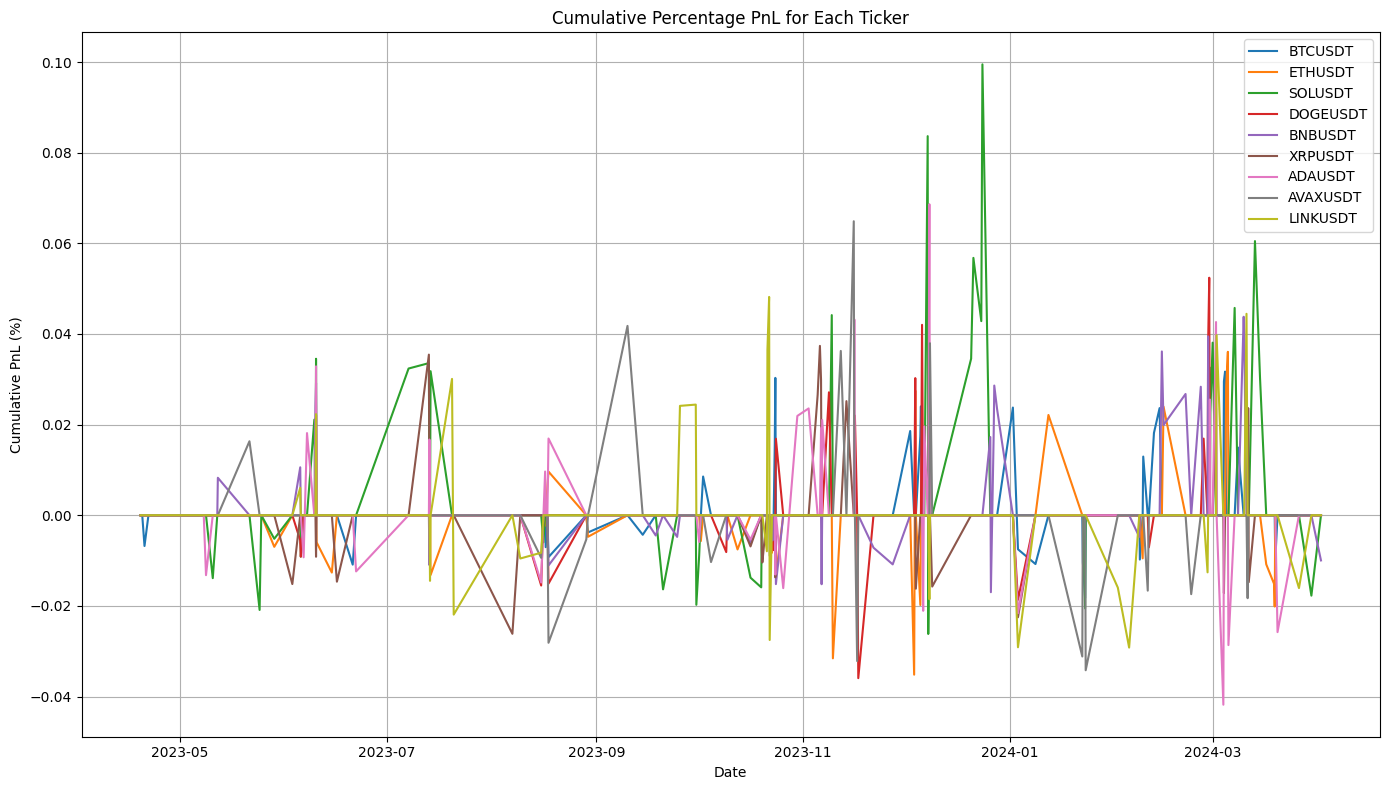

In [14]:
# Инициализация данных
tickers = ['BTCUSDT', 'ETHUSDT', 'SOLUSDT', 'DOGEUSDT', 'BNBUSDT', 'XRPUSDT', 'ADAUSDT', 'AVAXUSDT', 'LINKUSDT']

capital_fraction = 1 / len(tickers)
interval = 4

close_resampled = close.resample(f'{interval}H').last()
open_resampled = open.resample(f'{interval}H').first()
high_resampled = high.resample(f'{interval}H').max()
low_resampled = low.resample(f'{interval}H').min()
qvolume_resampled = qvolume.resample(f'{interval}H').sum()
bvolume_resampled = bvolume.resample(f'{interval}H').sum()

# Список для хранения DataFrame каждого тикера
ticker_pnl_dataframes = []

for ticker in tickers:
    # Создаем DataFrame с данными тикера за последний год
    data = pd.DataFrame({
        'close': close_resampled[ticker],
        'open': open_resampled[ticker],
        'high': high_resampled[ticker],
        'low': low_resampled[ticker],
        'qvolume': qvolume_resampled[ticker],
        'bvolume': bvolume_resampled[ticker]
    })
    data = data.iloc[-int(360 * 24 / interval):]  # Используем последние 360 записей (примерно год)

    # Идентифицируем pinbar свечи
    data = identify_pinbar(data)

    # Применение новой стратегии
    filtered_backtest_results = backtest_pinbar_with_filters(data)
    filtered_backtest_results.index = pd.to_datetime(filtered_backtest_results['date'])
    filtered_backtest_results.drop(columns=['date'], inplace=True)
    filtered_backtest_results.sort_index(inplace=True)

    # Расчет процентного PnL и кумулятивного процентного PnL
    filtered_backtest_results['pnl_pct'] = filtered_backtest_results.apply(
        lambda row: ((row['exit_price'] - row['entry_price']) / row['entry_price'])
        if row['signal'] == 'Buy' else ((row['entry_price'] - row['exit_price']) / row['entry_price']),
        axis=1
    ) * capital_fraction
    filtered_backtest_results['cumulative_pnl_pct'] = filtered_backtest_results['pnl_pct'].cumsum()

    # Добавляем начальные нулевые значения к кумулятивным PnL
    initial_date = filtered_backtest_results.index[0]
    filtered_backtest_results = pd.concat([
        pd.DataFrame({'cumulative_pnl_pct': [0]}, index=[initial_date]),
        filtered_backtest_results
    ], ignore_index=False)

    # Сброс и удаление дубликатов индекса перед добавлением в общий DataFrame
    filtered_backtest_results = (
        filtered_backtest_results[['pnl_pct']]
        .rename(columns={'pnl_pct': ticker})
        .reset_index()  # Сбрасываем индекс, чтобы избежать дубликатов
        .drop_duplicates(subset='index')  # Удаляем дублирующиеся даты
        .set_index('index')  # Снова устанавливаем индекс
    )
    ticker_pnl_dataframes.append(filtered_backtest_results)

# Объединяем все DataFrame по дате (outer join)
aggregate_df = pd.concat(ticker_pnl_dataframes, axis=1, join='outer').fillna(0)

# Построение графиков для каждого тикера
plt.figure(figsize=(14, 8))
for ticker in tickers:
    plt.plot(aggregate_df.index, aggregate_df[ticker], label=ticker)
plt.title('Cumulative Percentage PnL for Each Ticker')
plt.xlabel('Date')
plt.ylabel('Cumulative PnL (%)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

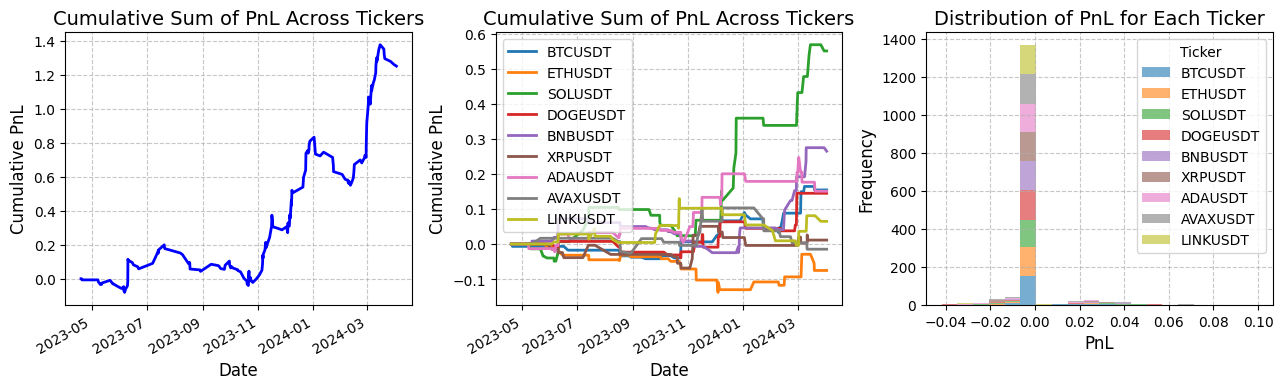

In [15]:
# Создаем фигуру с двумя подграфиками рядом
fig, axes = plt.subplots(1, 3, figsize=(13, 4))

# Линейный график кумулятивной суммы по строкам
aggregate_df.sum(axis=1).cumsum().plot(ax=axes[0], color='b', linewidth=2)
axes[0].set_title('Cumulative Sum of PnL Across Tickers', fontsize=14)
axes[0].set_xlabel('Date', fontsize=12)
axes[0].set_ylabel('Cumulative PnL', fontsize=12)
axes[0].grid(True, linestyle='--', alpha=0.7)

# Линейный график кумулятивной суммы по строкам
aggregate_df.cumsum().plot(ax=axes[1], linewidth=2)
axes[1].set_title('Cumulative Sum of PnL Across Tickers', fontsize=14)
axes[1].set_xlabel('Date', fontsize=12)
axes[1].set_ylabel('Cumulative PnL', fontsize=12)
axes[1].grid(True, linestyle='--', alpha=0.7)

# Гистограмма распределения PnL для каждого тикера
aggregate_df.plot(kind='hist', bins=20, alpha=0.6, ax=axes[2], stacked=True)
axes[2].set_title('Distribution of PnL for Each Ticker', fontsize=14)
axes[2].set_xlabel('PnL', fontsize=12)
axes[2].set_ylabel('Frequency', fontsize=12)
axes[2].legend(title="Ticker", fontsize=10)
axes[2].grid(True, linestyle='--', alpha=0.7)

# Настройка расстояния между графиками и отображение
plt.tight_layout()
plt.show()

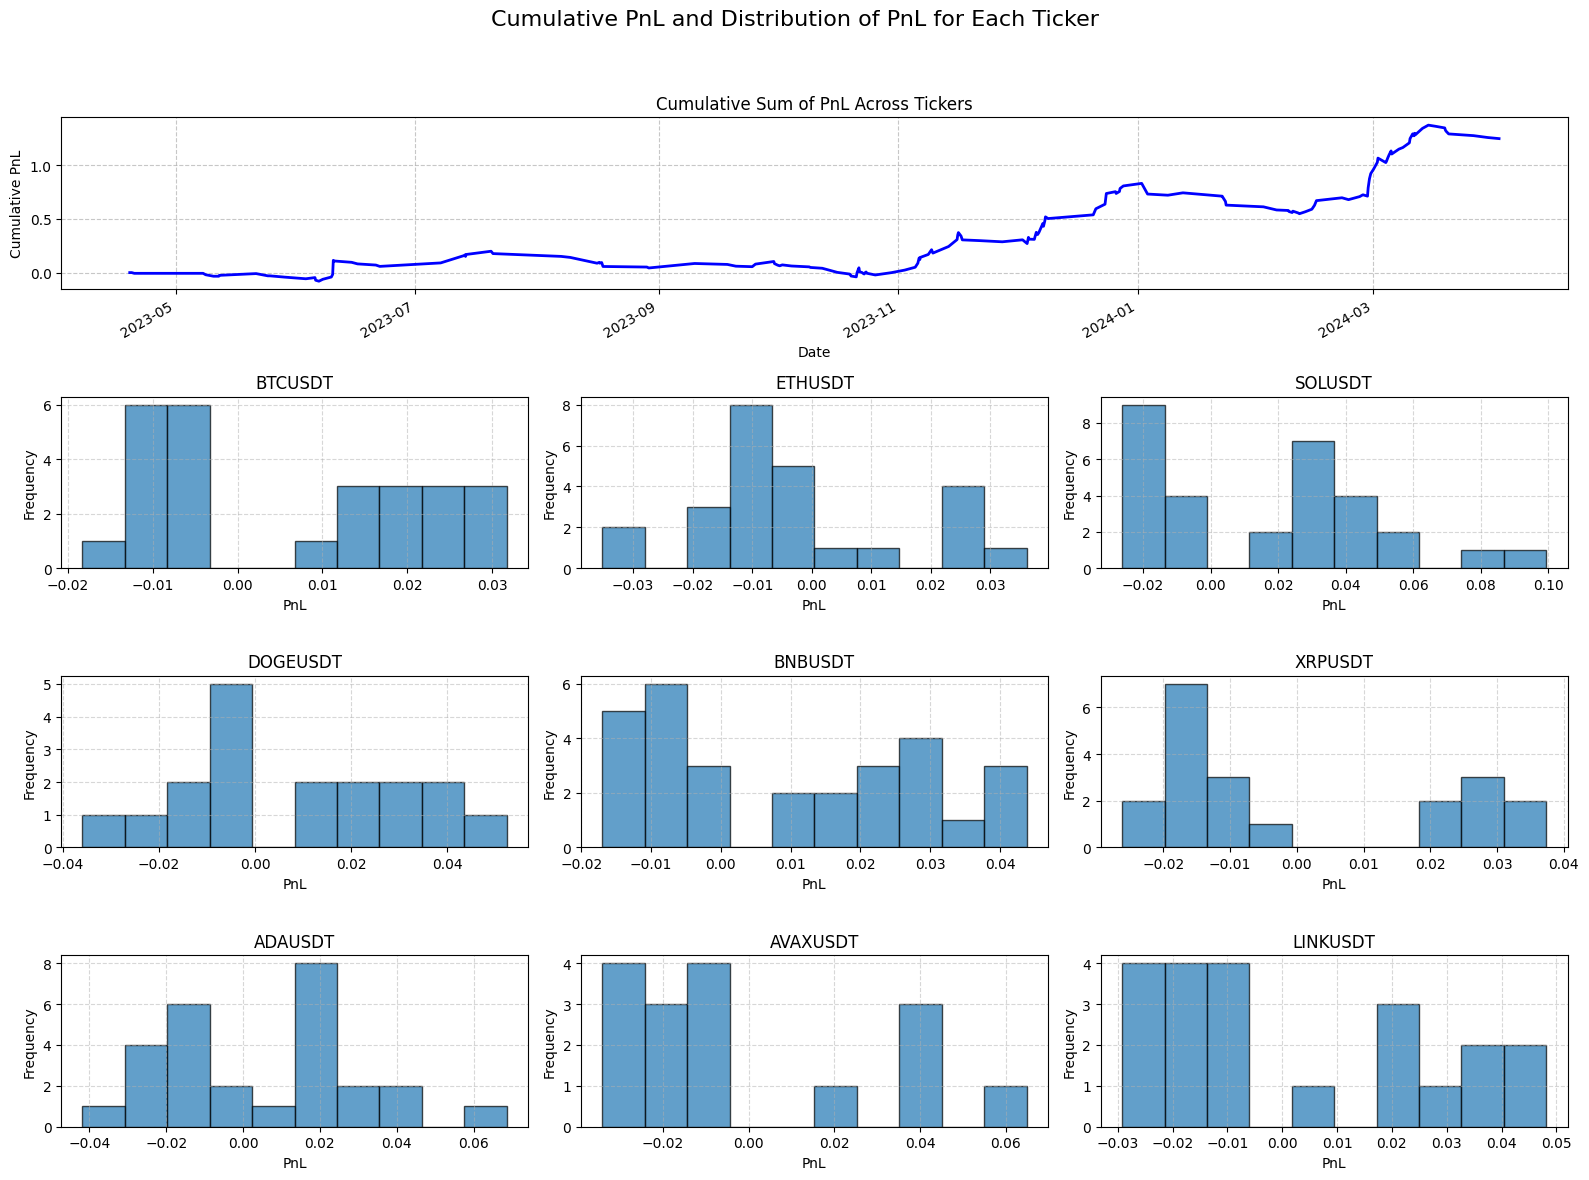

In [16]:
import math

# Определяем количество строк и столбцов для подграфиков
num_tickers = len(aggregate_df.columns)
n_cols = 3  # Число столбцов
n_rows = math.ceil(num_tickers / n_cols)  # Число строк для размещения всех графиков

# Создаем фигуру и подграфики
fig, axes = plt.subplots(n_rows + 1, n_cols, figsize=(16, 12))  # +1 строка для кумулятивного графика
fig.suptitle("Cumulative PnL and Distribution of PnL for Each Ticker", fontsize=16)

# График кумулятивной суммы PnL на первую строку, растянутую на всю ширину
cumulative_ax = fig.add_subplot(n_rows + 1, 1, 1)
aggregate_df.sum(axis=1).cumsum().plot(ax=cumulative_ax, color='b', linewidth=2)
cumulative_ax.set_title('Cumulative Sum of PnL Across Tickers')
cumulative_ax.set_xlabel('Date')
cumulative_ax.set_ylabel('Cumulative PnL')
cumulative_ax.grid(True, linestyle='--', alpha=0.7)

# Построение гистограммы распределения PnL для каждого тикера
for idx, column in enumerate(aggregate_df.columns):
    row, col = divmod(idx, n_cols)
    axes[row + 1, col].hist(aggregate_df[column][aggregate_df[column] != 0], bins=10, edgecolor='k', alpha=0.7)
    axes[row + 1, col].set_title(column, fontsize=12)
    axes[row + 1, col].set_xlabel('PnL')
    axes[row + 1, col].set_ylabel('Frequency')
    axes[row + 1, col].grid(True, linestyle='--', alpha=0.5)

# Удаление пустых подграфиков, если тикеров меньше, чем подграфиков
for ax in axes.flat:
    if not ax.has_data():
        ax.axis('off')

# Настройка расстояния между графиками и отображение
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

<Axes: xlabel='date'>

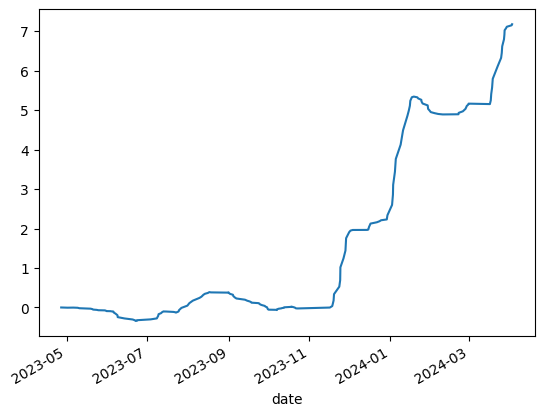

In [17]:
def backtest_golden_cross(df, short_window=50, long_window=200):
    # Рассчитываем скользящие средние
    df['short_ma'] = df['close'].rolling(window=short_window).mean()
    df['long_ma'] = df['close'].rolling(window=long_window).mean()

    # Словарь для хранения сигналов и результатов
    signals = {
        'date': [], 'signal': [], 'entry_price': [], 'exit_price': [],
        'exit_reason': [], 'pnl': []
    }
    position = None
    entry_price = None

    for i in range(long_window, len(df)):
        if position is None:
            # Золотой крест - покупка
            if df['short_ma'].iloc[i] > df['long_ma'].iloc[i]:
                position = 'Buy'
                entry_price = df['close'].iloc[i]
                signals['date'].append(df.index[i])
                signals['signal'].append(position)
                signals['entry_price'].append(entry_price)
                signals['exit_price'].append(None)
                signals['exit_reason'].append(None)
                signals['pnl'].append(0)  # Начальный PnL по позиции
        elif position == 'Buy':
            # Крест смерти - продажа
            if df['short_ma'].iloc[i] < df['long_ma'].iloc[i]:
                exit_price = df['close'].iloc[i]
                pnl = (exit_price - entry_price) / entry_price  # Рассчитываем доходность сделки
                signals['date'].append(df.index[i])
                signals['signal'].append('Sell')
                signals['entry_price'].append(None)
                signals['exit_price'].append(exit_price)
                signals['exit_reason'].append('Death Cross')
                signals['pnl'].append(pnl)
                
                # Закрываем позицию
                position = None

    # Формируем DataFrame с результатами
    results_df = pd.DataFrame(signals)
    return results_df

interval = 4

close_resampled = close.resample(f'{interval}H').last()
open_resampled = open.resample(f'{interval}H').first()
high_resampled = high.resample(f'{interval}H').max()
low_resampled = low.resample(f'{interval}H').min()
qvolume_resampled = qvolume.resample(f'{interval}H').sum()
bvolume_resampled = bvolume.resample(f'{interval}H').sum()

all_pnl = {}

for ticker in tickers:
    data = pd.DataFrame({
            'close': close_resampled[ticker],
            'open': open_resampled[ticker],
            'high': high_resampled[ticker],
            'low': low_resampled[ticker],
            'qvolume': qvolume_resampled[ticker],
            'bvolume': bvolume_resampled[ticker]
        })


  # Применение функции и расчет кумулятивного PnL
    results_df = backtest_golden_cross(data.iloc[int(-360 * 24 / interval):], 30, 90)
    results_df['cumulative_pnl'] = ((1 + results_df['pnl']).cumprod() - 1) / 100  # Кумулятивный процентный PnL
    results_df.index = pd.to_datetime(results_df['date'])
    all_pnl[ticker] = results_df['pnl']

pd.DataFrame(all_pnl).ffill().fillna(0).cumsum().mean(axis=1).plot()

In [18]:
def backtest_golden_cross(df, short_window=50, long_window=200, tp_factor=8, sl_factor=1):
    # Рассчитываем скользящие средние
    df['short_ma'] = df['close'].rolling(window=short_window).mean()
    df['long_ma'] = df['close'].rolling(window=long_window).mean()

    # Словарь для хранения сигналов и результатов
    signals = {
        'date': [], 'signal': [], 'entry_price': [], 'exit_price': [],
        'exit_reason': [], 'pnl': []
    }
    position = None
    entry_price = None
    take_profit = None
    stop_loss = None

    for i in range(long_window, len(df)):
        if position is None:
            # Золотой крест - покупка
            if df['short_ma'].iloc[i] > df['long_ma'].iloc[i]:
                entry_price = df['close'].iloc[i]
                take_profit = entry_price * (1 + tp_factor / 100)  # TP на расстоянии tp_factor% от входа
                stop_loss = entry_price * (1 - sl_factor / 100)    # SL на расстоянии sl_factor% от входа

                position = 'Buy'
                signals['date'].append(df.index[i])
                signals['signal'].append(position)
                signals['entry_price'].append(entry_price)
                signals['exit_price'].append(None)
                signals['exit_reason'].append(None)
                signals['pnl'].append(0)  # Начальный PnL по позиции

        elif position == 'Buy':
            current_price = df['close'].iloc[i]

            # Проверка условий для TP и SL
            if current_price >= take_profit:
                pnl = (take_profit - entry_price) / entry_price  # PnL при достижении TP
                signals['date'].append(df.index[i])
                signals['signal'].append('Sell')
                signals['entry_price'].append(None)
                signals['exit_price'].append(take_profit)
                signals['exit_reason'].append('Take Profit')
                signals['pnl'].append(pnl)

                position = None  # Закрываем позицию

            elif current_price <= stop_loss:
                pnl = (stop_loss - entry_price) / entry_price  # PnL при достижении SL
                signals['date'].append(df.index[i])
                signals['signal'].append('Sell')
                signals['entry_price'].append(None)
                signals['exit_price'].append(stop_loss)
                signals['exit_reason'].append('Stop Loss')
                signals['pnl'].append(pnl)

                position = None  # Закрываем позицию

            # Закрытие позиции при «Кресте смерти»
            elif df['short_ma'].iloc[i] < df['long_ma'].iloc[i]:
                pnl = (current_price - entry_price) / entry_price  # PnL при обратном сигнале
                signals['date'].append(df.index[i])
                signals['signal'].append('Sell')
                signals['entry_price'].append(None)
                signals['exit_price'].append(current_price)
                signals['exit_reason'].append('Death Cross')
                signals['pnl'].append(pnl)

                position = None  # Закрываем позицию

    # Формируем DataFrame с результатами
    results_df = pd.DataFrame(signals)
    return results_df

# Пример использования функции и визуализация результатов
interval = 4
close_resampled = close.resample(f'{interval}H').last()
all_pnl = {}

for ticker in tickers:
    close_resampled = close.resample(f'{interval}H').last()
    open_resampled = open.resample(f'{interval}H').first()
    high_resampled = high.resample(f'{interval}H').max()
    low_resampled = low.resample(f'{interval}H').min()
    qvolume_resampled = qvolume.resample(f'{interval}H').sum()
    bvolume_resampled = bvolume.resample(f'{interval}H').sum()

    data = pd.DataFrame({
            'close': close_resampled[ticker],
            'open': open_resampled[ticker],
            'high': high_resampled[ticker],
            'low': low_resampled[ticker],
            'qvolume': qvolume_resampled[ticker],
            'bvolume': bvolume_resampled[ticker]
        })

    # Применение функции и расчет кумулятивного PnL
    results_df = backtest_golden_cross(data, 30, 90, tp_factor=12, sl_factor=1)
    results_df['cumulative_pnl'] = ((1 + results_df['pnl']).cumprod() - 1) * 100  # Кумулятивный процентный PnL
    results_df.index = pd.to_datetime(results_df['date'])
    all_pnl[ticker] = results_df['pnl']

# # Построение графика для среднего кумулятивного PnL по всем тикерам
# pd.DataFrame(all_pnl).ffill().fillna(0).cumsum().mean(axis=1).plot()
# plt.title("Cumulative PnL with Take Profit and Stop Loss")
# plt.xlabel("Date")
# plt.ylabel("Cumulative PnL (%)")
# plt.grid()
# plt.show()

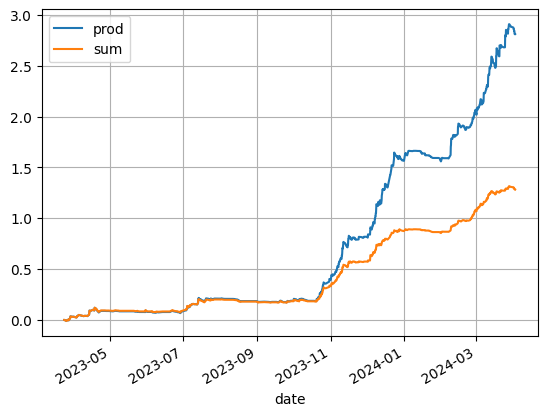

In [25]:
((pd.DataFrame(all_pnl).fillna(0) + 1).iloc[-1000:].cumprod() - 1).mean(axis=1).plot(label='prod') # .iloc[-500:].cumsum().mean(axis=1).plot()
((pd.DataFrame(all_pnl).fillna(0)).iloc[-1000:].cumsum()).mean(axis=1).plot(label='sum')
plt.grid(True)
plt.legend()
plt.show()

In [52]:
import pandas as pd
import matplotlib.pyplot as plt

def backtest_golden_cross(df, short_window=50, long_window=200, tp_factor=8, sl_factor=1):
    # Рассчитываем скользящие средние
    df['short_ma'] = df['close'].rolling(window=short_window).mean()
    df['long_ma'] = df['close'].rolling(window=long_window).mean()

    # Словарь для хранения сигналов и результатов
    signals = {
        'date': [], 'signal': [], 'entry_price': [], 'exit_price': [],
        'exit_reason': [], 'pnl': []
    }
    position = None
    entry_price = None
    take_profit = None
    stop_loss = None

    for i in range(long_window, len(df)):
        current_price = df['close'].iloc[i]

        # Если позиция не открыта, ищем сигнал для открытия позиции
        if position is None:
            # Золотой крест - открываем лонг
            if df['short_ma'].iloc[i] > df['long_ma'].iloc[i] and df['short_ma'].iloc[i - 1] <= df['long_ma'].iloc[i - 1]:
                entry_price = current_price
                take_profit = entry_price * (1 + tp_factor / 100)
                stop_loss = entry_price * (1 - sl_factor / 100)
                
                position = 'Buy'
                signals['date'].append(df.index[i])
                signals['signal'].append(position)
                signals['entry_price'].append(entry_price)
                signals['exit_price'].append(None)
                signals['exit_reason'].append(None)
                signals['pnl'].append(0)  # Начальный PnL по позиции

            # Крест смерти - открываем шорт
            elif df['short_ma'].iloc[i] < df['long_ma'].iloc[i] and df['short_ma'].iloc[i - 1] >= df['long_ma'].iloc[i - 1]:
                entry_price = current_price
                take_profit = entry_price * (1 - tp_factor / 100)
                stop_loss = entry_price * (1 + sl_factor / 100)
                
                position = 'Sell'
                signals['date'].append(df.index[i])
                signals['signal'].append(position)
                signals['entry_price'].append(entry_price)
                signals['exit_price'].append(None)
                signals['exit_reason'].append(None)
                signals['pnl'].append(0)  # Начальный PnL по позиции

        # Если позиция открыта, проверяем условия для закрытия
        elif position == 'Buy':
            # Проверка TP и SL для лонга
            if current_price >= take_profit:
                pnl = (take_profit - entry_price) / entry_price
                signals['date'].append(df.index[i])
                signals['signal'].append('Sell')
                signals['entry_price'].append(None)
                signals['exit_price'].append(take_profit)
                signals['exit_reason'].append('Take Profit')
                signals['pnl'].append(pnl)
                position = None  # Закрываем позицию

            elif current_price <= stop_loss:
                pnl = (stop_loss - entry_price) / entry_price
                signals['date'].append(df.index[i])
                signals['signal'].append('Sell')
                signals['entry_price'].append(None)
                signals['exit_price'].append(stop_loss)
                signals['exit_reason'].append('Stop Loss')
                signals['pnl'].append(pnl)
                position = None  # Закрываем позицию

        elif position == 'Sell':
            # Проверка TP и SL для шорта
            if current_price <= take_profit:
                pnl = (entry_price - take_profit) / entry_price
                signals['date'].append(df.index[i])
                signals['signal'].append('Buy')
                signals['entry_price'].append(None)
                signals['exit_price'].append(take_profit)
                signals['exit_reason'].append('Take Profit')
                signals['pnl'].append(pnl)
                position = None  # Закрываем позицию

            elif current_price >= stop_loss:
                pnl = (entry_price - stop_loss) / entry_price
                signals['date'].append(df.index[i])
                signals['signal'].append('Buy')
                signals['entry_price'].append(None)
                signals['exit_price'].append(stop_loss)
                signals['exit_reason'].append('Stop Loss')
                signals['pnl'].append(pnl)
                position = None  # Закрываем позицию

    # Формируем DataFrame с результатами
    results_df = pd.DataFrame(signals)
    return results_df

# Пример использования функции и визуализация результатов
interval = 4
close_resampled = close.resample(f'{interval}H').last()
all_pnl = {}

for ticker in tickers:
    close_resampled = close.resample(f'{interval}H').last()
    open_resampled = open.resample(f'{interval}H').first()
    high_resampled = high.resample(f'{interval}H').max()
    low_resampled = low.resample(f'{interval}H').min()
    qvolume_resampled = qvolume.resample(f'{interval}H').sum()
    bvolume_resampled = bvolume.resample(f'{interval}H').sum()

    data = pd.DataFrame({
            'close': close_resampled[ticker],
            'open': open_resampled[ticker],
            'high': high_resampled[ticker],
            'low': low_resampled[ticker],
            'qvolume': qvolume_resampled[ticker],
            'bvolume': bvolume_resampled[ticker]
        })

    # Применение функции и расчет кумулятивного PnL
    results_df = backtest_golden_cross(data, 30, 90, tp_factor=15, sl_factor=1)
    results_df['cumulative_pnl'] = ((1 + results_df['pnl']).cumprod() - 1) * 100  # Кумулятивный процентный PnL
    results_df.index = pd.to_datetime(results_df['date'])
    all_pnl[ticker] = results_df['pnl']

<Axes: xlabel='date'>

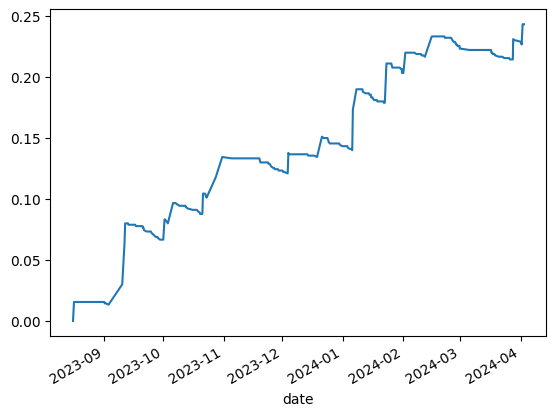

In [53]:
pd.DataFrame(all_pnl).fillna(0).iloc[-200:].cumsum().mean(axis=1).plot()

In [221]:
def backtest_golden_cross(df, short_window=50, long_window=200, tp_factor=8, sl_factor=1):
    # Рассчитываем скользящие средние
    df['short_ma'] = df['close'].rolling(window=short_window).mean()
    df['long_ma'] = df['close'].rolling(window=long_window).mean()

    # Словарь для хранения сигналов и результатов
    signals = {
        'date': [], 'signal': [], 'entry_price': [], 'exit_price': [],
        'exit_reason': [], 'pnl': []
    }
    position = None
    entry_price = None
    take_profit = None
    stop_loss = None

    for i in range(long_window, len(df)):
        current_price = df['close'].iloc[i]

        # Если позиция не открыта, ищем сигнал для открытия позиции
        if position is None:
            # Золотой крест - открываем лонг
            if df['short_ma'].iloc[i] > df['long_ma'].iloc[i] and df['short_ma'].iloc[i - 1] <= df['long_ma'].iloc[i - 1]:
                entry_price = current_price
                take_profit = entry_price * (1 + tp_factor / 100)
                stop_loss = entry_price * (1 - sl_factor / 100)
                
                position = 'Buy'
                signals['date'].append(df.index[i])
                signals['signal'].append(position)
                signals['entry_price'].append(entry_price)
                signals['exit_price'].append(None)
                signals['exit_reason'].append(None)
                signals['pnl'].append(0)  # Начальный PnL по позиции

            # Крест смерти - открываем шорт
            elif df['short_ma'].iloc[i] < df['long_ma'].iloc[i] and df['short_ma'].iloc[i - 1] >= df['long_ma'].iloc[i - 1]:
                entry_price = current_price
                take_profit = entry_price * (1 - tp_factor / 100)
                stop_loss = entry_price * (1 + sl_factor / 100)
                
                position = 'Sell'
                signals['date'].append(df.index[i])
                signals['signal'].append(position)
                signals['entry_price'].append(entry_price)
                signals['exit_price'].append(None)
                signals['exit_reason'].append(None)
                signals['pnl'].append(0)  # Начальный PnL по позиции

        # Если позиция открыта, проверяем условия для закрытия и смены позиции
        elif position == 'Buy':
            # Проверка TP и SL для лонга
            if current_price >= take_profit:
                pnl = (take_profit - entry_price) / entry_price
                signals['date'].append(df.index[i])
                signals['signal'].append('Sell')
                signals['entry_price'].append(None)
                signals['exit_price'].append(take_profit)
                signals['exit_reason'].append('Take Profit')
                signals['pnl'].append(pnl)
                position = None  # Закрываем позицию

            elif current_price <= stop_loss:
                pnl = (stop_loss - entry_price) / entry_price
                signals['date'].append(df.index[i])
                signals['signal'].append('Sell')
                signals['entry_price'].append(None)
                signals['exit_price'].append(stop_loss)
                signals['exit_reason'].append('Stop Loss')
                signals['pnl'].append(pnl)
                position = None  # Закрываем позицию

            # Проверка на сигнал на шорт (Крест смерти) - закрываем лонг и открываем шорт
            elif df['short_ma'].iloc[i] < df['long_ma'].iloc[i] and df['short_ma'].iloc[i - 1] >= df['long_ma'].iloc[i - 1]:
                pnl = (current_price - entry_price) / entry_price
                signals['date'].append(df.index[i])
                signals['signal'].append('Sell')
                signals['entry_price'].append(None)
                signals['exit_price'].append(current_price)
                signals['exit_reason'].append('Death Cross')
                signals['pnl'].append(pnl)
                
                # Устанавливаем параметры для новой позиции (шорт) без добавления новой записи
                entry_price = current_price
                take_profit = entry_price * (1 - tp_factor / 100)
                stop_loss = entry_price * (1 + sl_factor / 100)
                
                position = 'Sell'

        elif position == 'Sell':
            # Проверка TP и SL для шорта
            if current_price <= take_profit:
                pnl = (entry_price - take_profit) / entry_price
                signals['date'].append(df.index[i])
                signals['signal'].append('Buy')
                signals['entry_price'].append(None)
                signals['exit_price'].append(take_profit)
                signals['exit_reason'].append('Take Profit')
                signals['pnl'].append(pnl)
                position = None  # Закрываем позицию

            elif current_price >= stop_loss:
                pnl = (entry_price - stop_loss) / entry_price
                signals['date'].append(df.index[i])
                signals['signal'].append('Buy')
                signals['entry_price'].append(None)
                signals['exit_price'].append(stop_loss)
                signals['exit_reason'].append('Stop Loss')
                signals['pnl'].append(pnl)
                position = None  # Закрываем позицию

            # Проверка на сигнал на лонг (Золотой крест) - закрываем шорт и открываем лонг
            elif df['short_ma'].iloc[i] > df['long_ma'].iloc[i] and df['short_ma'].iloc[i - 1] <= df['long_ma'].iloc[i - 1]:
                pnl = (entry_price - current_price) / entry_price
                signals['date'].append(df.index[i])
                signals['signal'].append('Buy')
                signals['entry_price'].append(None)
                signals['exit_price'].append(current_price)
                signals['exit_reason'].append('Golden Cross')
                signals['pnl'].append(pnl)
                
                # Устанавливаем параметры для новой позиции (лонг) без добавления новой записи
                entry_price = current_price
                take_profit = entry_price * (1 + tp_factor / 100)
                stop_loss = entry_price * (1 - sl_factor / 100)
                
                position = 'Buy'

    # Формируем DataFrame с результатами
    results_df = pd.DataFrame(signals)
    return results_df

# Проверим стратегию на данных
interval = 4
close_resampled = close.resample(f'{interval}H').last()
all_pnl = {}

for ticker in tickers:
    close_resampled = close.resample(f'{interval}H').last().sort_index()
    open_resampled = open.resample(f'{interval}H').first().sort_index()
    high_resampled = high.resample(f'{interval}H').max().sort_index()
    low_resampled = low.resample(f'{interval}H').min().sort_index()
    qvolume_resampled = qvolume.resample(f'{interval}H').sum().sort_index()
    bvolume_resampled = bvolume.resample(f'{interval}H').sum().sort_index()

    data = pd.DataFrame({
            'close': close_resampled[ticker],
            'open': open_resampled[ticker],
            'high': high_resampled[ticker],
            'low': low_resampled[ticker],
            'qvolume': qvolume_resampled[ticker],
            'bvolume': bvolume_resampled[ticker]
        })

    # Применение функции и расчет кумулятивного PnL
    results_df = backtest_golden_cross(data, 30, 90, tp_factor=20, sl_factor=2)
    results_df['cumulative_pnl'] = ((1 + results_df['pnl']).cumprod() - 1) * 100  # Кумулятивный процентный PnL
    results_df.index = pd.to_datetime(results_df['date'])
    all_pnl[ticker] = results_df['pnl']

In [223]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

leverage = 1

# Генерируем данные для графиков
cumulative_pnl = (pd.DataFrame(all_pnl) * leverage).fillna(0).iloc[-100:].cumsum().mean(axis=1)
drawdown = (cumulative_pnl.cummax() - cumulative_pnl) / (cumulative_pnl.cummax() + 1)

# Создаем фигуру с двумя подграфиками рядом
fig = make_subplots(rows=1, cols=2, subplot_titles=("Cumulative PnL", "Drawdown"))

# Добавляем график Cumulative PnL
fig.add_trace(
    go.Scatter(x=cumulative_pnl.index, y=cumulative_pnl, mode="lines", name="Cumulative PnL"),
    row=1, col=1
)

# Добавляем график Drawdown
fig.add_trace(
    go.Scatter(x=drawdown.index, y=drawdown, mode="lines", name="Drawdown"),
    row=1, col=2
)

# Настраиваем общие параметры оформления графиков
fig.update_layout(
    title="Cumulative PnL and Drawdown",
    xaxis_title="Date",
    yaxis_title="PnL",
    xaxis2_title="Date",
    yaxis2_title="Drawdown",
    hovermode="x unified",  # Единый режим отображения подсказок для всех графиков
    template="plotly_white"
)

# Настраиваем оси для удобного масштабирования
fig.update_xaxes(rangeslider_visible=True)
fig.update_yaxes(fixedrange=False)

# Отображаем график
fig.show()

In [224]:
def backtest_golden_cross(df, short_window=50, long_window=200, tp_factor=8, sl_factor=1, maker_fee=0.0002, taker_fee=0.0005):
    df['short_ma'] = df['close'].rolling(window=short_window).mean()
    df['long_ma'] = df['close'].rolling(window=long_window).mean()
    
    signals = {
        'date': [], 'signal': [], 'entry_price': [], 'exit_price': [], 'exit_reason': [],
        'pnl': [], 'pnl_maker': [], 'pnl_taker': []
    }
    position = None
    entry_price = None
    take_profit = None
    stop_loss = None

    for i in range(long_window, len(df)):
        current_price = df['close'].iloc[i]
        
        # Если позиция не открыта, ищем сигнал для открытия позиции
        if position is None:
            # Золотой крест - открываем лонг
            if df['short_ma'].iloc[i] > df['long_ma'].iloc[i] and df['short_ma'].iloc[i - 1] <= df['long_ma'].iloc[i - 1]:
                entry_price = current_price
                take_profit = entry_price * (1 + tp_factor / 100)
                stop_loss = entry_price * (1 - sl_factor / 100)
                
                position = 'Buy'
                signals['date'].append(df.index[i])
                signals['signal'].append(position)
                signals['entry_price'].append(entry_price)
                signals['exit_price'].append(None)
                signals['exit_reason'].append(None)
                signals['pnl'].append(0)
                signals['pnl_maker'].append(0)  # Начальный PnL с мейкерской комиссией
                signals['pnl_taker'].append(0)  # Начальный PnL с тейкерской комиссией

            # Крест смерти - открываем шорт
            elif df['short_ma'].iloc[i] < df['long_ma'].iloc[i] and df['short_ma'].iloc[i - 1] >= df['long_ma'].iloc[i - 1]:
                entry_price = current_price
                take_profit = entry_price * (1 - tp_factor / 100)
                stop_loss = entry_price * (1 + sl_factor / 100)
                
                position = 'Sell'
                signals['date'].append(df.index[i])
                signals['signal'].append(position)
                signals['entry_price'].append(entry_price)
                signals['exit_price'].append(None)
                signals['exit_reason'].append(None)
                signals['pnl'].append(0)
                signals['pnl_maker'].append(0)
                signals['pnl_taker'].append(0)

        # Если позиция открыта, проверяем условия для закрытия и смены позиции
        elif position == 'Buy':
            if current_price >= take_profit:
                pnl = (take_profit - entry_price) / entry_price
                pnl_maker = pnl - maker_fee
                pnl_taker = pnl - taker_fee
                signals['date'].append(df.index[i])
                signals['signal'].append('Sell')
                signals['entry_price'].append(None)
                signals['exit_price'].append(take_profit)
                signals['exit_reason'].append('Take Profit')
                signals['pnl'].append(pnl)
                signals['pnl_maker'].append(pnl_maker)
                signals['pnl_taker'].append(pnl_taker)
                position = None

            elif current_price <= stop_loss:
                pnl = (stop_loss - entry_price) / entry_price
                pnl_maker = pnl - maker_fee
                pnl_taker = pnl - taker_fee
                signals['date'].append(df.index[i])
                signals['signal'].append('Sell')
                signals['entry_price'].append(None)
                signals['exit_price'].append(stop_loss)
                signals['exit_reason'].append('Stop Loss')
                signals['pnl'].append(pnl)
                signals['pnl_maker'].append(pnl_maker)
                signals['pnl_taker'].append(pnl_taker)
                position = None

            elif df['short_ma'].iloc[i] < df['long_ma'].iloc[i] and df['short_ma'].iloc[i - 1] >= df['long_ma'].iloc[i - 1]:
                pnl = (current_price - entry_price) / entry_price
                pnl_maker = pnl - maker_fee
                pnl_taker = pnl - taker_fee
                signals['date'].append(df.index[i])
                signals['signal'].append('Sell')
                signals['entry_price'].append(None)
                signals['exit_price'].append(current_price)
                signals['exit_reason'].append('Death Cross')
                signals['pnl'].append(pnl)
                signals['pnl_maker'].append(pnl_maker)
                signals['pnl_taker'].append(pnl_taker)
                
                entry_price = current_price
                take_profit = entry_price * (1 - tp_factor / 100)
                stop_loss = entry_price * (1 + sl_factor / 100)
                position = 'Sell'

        elif position == 'Sell':
            if current_price <= take_profit:
                pnl = (entry_price - take_profit) / entry_price
                pnl_maker = pnl - maker_fee
                pnl_taker = pnl - taker_fee
                signals['date'].append(df.index[i])
                signals['signal'].append('Buy')
                signals['entry_price'].append(None)
                signals['exit_price'].append(take_profit)
                signals['exit_reason'].append('Take Profit')
                signals['pnl'].append(pnl)
                signals['pnl_maker'].append(pnl_maker)
                signals['pnl_taker'].append(pnl_taker)
                position = None

            elif current_price >= stop_loss:
                pnl = (entry_price - stop_loss) / entry_price
                pnl_maker = pnl - maker_fee
                pnl_taker = pnl - taker_fee
                signals['date'].append(df.index[i])
                signals['signal'].append('Buy')
                signals['entry_price'].append(None)
                signals['exit_price'].append(stop_loss)
                signals['exit_reason'].append('Stop Loss')
                signals['pnl'].append(pnl)
                signals['pnl_maker'].append(pnl_maker)
                signals['pnl_taker'].append(pnl_taker)
                position = None

            elif df['short_ma'].iloc[i] > df['long_ma'].iloc[i] and df['short_ma'].iloc[i - 1] <= df['long_ma'].iloc[i - 1]:
                pnl = (entry_price - current_price) / entry_price
                pnl_maker = pnl - maker_fee
                pnl_taker = pnl - taker_fee
                signals['date'].append(df.index[i])
                signals['signal'].append('Buy')
                signals['entry_price'].append(None)
                signals['exit_price'].append(current_price)
                signals['exit_reason'].append('Golden Cross')
                signals['pnl'].append(pnl)
                signals['pnl_maker'].append(pnl_maker)
                signals['pnl_taker'].append(pnl_taker)
                
                entry_price = current_price
                take_profit = entry_price * (1 + tp_factor / 100)
                stop_loss = entry_price * (1 - sl_factor / 100)
                position = 'Buy'

    results_df = pd.DataFrame(signals)
    return results_df

# Проверим стратегию на данных
interval = 4
close_resampled = close.resample(f'{interval}H').last()
all_pnl_no_fees = {}
all_pnl_maker_fees = {}
all_pnl_taker_fees = {}

for ticker in tickers:
    close_resampled = close.resample(f'{interval}H').last().sort_index()
    open_resampled = open.resample(f'{interval}H').first().sort_index()
    high_resampled = high.resample(f'{interval}H').max().sort_index()
    low_resampled = low.resample(f'{interval}H').min().sort_index()
    qvolume_resampled = qvolume.resample(f'{interval}H').sum().sort_index()
    bvolume_resampled = bvolume.resample(f'{interval}H').sum().sort_index()

    data = pd.DataFrame({
            'close': close_resampled[ticker],
            'open': open_resampled[ticker],
            'high': high_resampled[ticker],
            'low': low_resampled[ticker],
            'qvolume': qvolume_resampled[ticker],
            'bvolume': bvolume_resampled[ticker]
        })

    # Применение функции и расчет кумулятивного PnL
    results_df = backtest_golden_cross(data, 30, 90, tp_factor=20, sl_factor=2)
    results_df['cumulative_pnl'] = ((1 + results_df['pnl']).cumprod() - 1) * 100  # Кумулятивный процентный PnL
    results_df.index = pd.to_datetime(results_df['date'])
    all_pnl[ticker] = results_df['pnl']
    all_pnl_maker_fees[ticker] = results_df['pnl_maker']
    all_pnl_taker_fees[ticker] = results_df['pnl_taker']

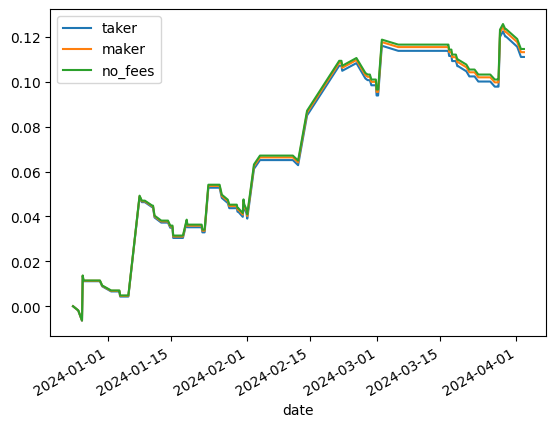

In [240]:
pd.DataFrame(all_pnl_taker_fees).fillna(0).iloc[-100:].cumsum().mean(axis=1).plot(label='taker')
pd.DataFrame(all_pnl_maker_fees).fillna(0).iloc[-100:].cumsum().mean(axis=1).plot(label='maker')
pd.DataFrame(all_pnl).fillna(0).iloc[-100:].cumsum().mean(axis=1).plot(label='no_fees')

plt.legend()
plt.show()

In [243]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

leverage = 3

# Генерируем данные для графиков
cumulative_pnl = (pd.DataFrame(all_pnl_taker_fees) * leverage).fillna(0).iloc[-200:].cumsum().mean(axis=1)
drawdown = (cumulative_pnl.cummax() - cumulative_pnl) / (cumulative_pnl.cummax() + 1)

# Создаем фигуру с двумя подграфиками рядом
fig = make_subplots(rows=1, cols=2, subplot_titles=("Cumulative PnL", "Drawdown"))

# Добавляем график Cumulative PnL
fig.add_trace(
    go.Scatter(x=cumulative_pnl.index, y=cumulative_pnl, mode="lines", name="Cumulative PnL"),
    row=1, col=1
)

# Добавляем график Drawdown
fig.add_trace(
    go.Scatter(x=drawdown.index, y=drawdown, mode="lines", name="Drawdown"),
    row=1, col=2
)

# Настраиваем общие параметры оформления графиков
fig.update_layout(
    title="Cumulative PnL and Drawdown",
    xaxis_title="Date",
    yaxis_title="PnL",
    xaxis2_title="Date",
    yaxis2_title="Drawdown",
    hovermode="x unified",  # Единый режим отображения подсказок для всех графиков
    template="plotly_white"
)

# Настраиваем оси для удобного масштабирования
fig.update_xaxes(rangeslider_visible=True)
fig.update_yaxes(fixedrange=False)

# Отображаем график
fig.show()